In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split

In [2]:
from keras import backend as K
from keras.models import Model

from keras.layers import (Activation, 
                          Conv2D, 
                          MaxPooling2D,
                          Input,
                          BatchNormalization, 
                          UpSampling2D, 
                          Concatenate)

from keras import regularizers, optimizers

from keras.callbacks import History, ReduceLROnPlateau, CSVLogger,ModelCheckpoint

In [3]:
def plot_images_and_labels(img_path, label_path):
    image = io.imread(img_path, as_gray=True)
    label = io.imread(label_path)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Изображение')

    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')
    plt.title('Маска')

    plt.show()

In [4]:
images_filenames_train = []
labels_filenames_train = []

path_name = 'разметка'
path = os.listdir(path=path_name)

for p in path:
    path_images = os.listdir(path=path_name + '/' + p + '/Images/')
    path_labels = os.listdir(path=path_name + '/' + p + '/Pigment/')
    for n in path_images:
        images_filenames_train.append(path_name + '/' + p + '/Images/' + n)
    for n in path_labels:
        labels_filenames_train.append(path_name + '/' + p + '/Pigment/' + n)

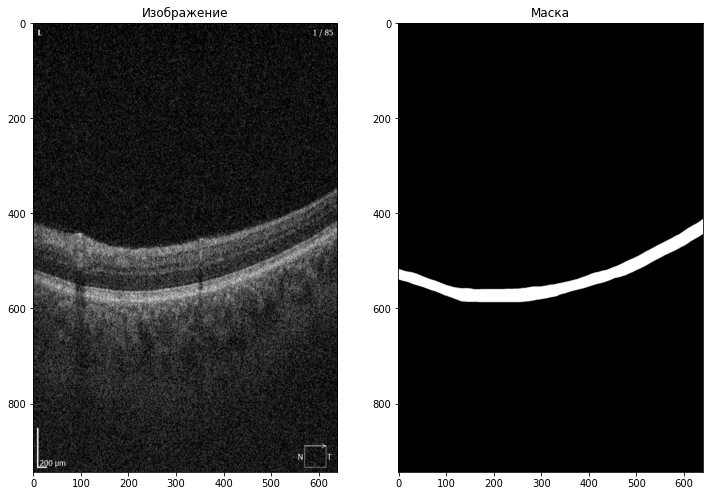

In [5]:
plot_images_and_labels(images_filenames_train[0], labels_filenames_train[0])

In [11]:
output_size = (256, 256)
resized_images, resized_labels = [], []

for im, l in tqdm(zip(images_filenames_train, labels_filenames_train)):
    image = Image.open(im)
    image = image.crop((64, 250, 576, 762))
    image = image.resize(output_size)
    label = Image.open(l)
    label = label.crop((64, 250, 576, 762))
    label = label.resize(output_size)
    resized_images.append(image)
    resized_labels.append(label)

510it [00:13, 38.51it/s]


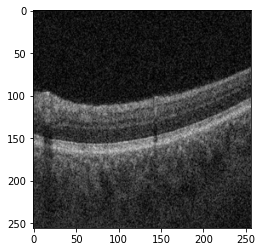

In [12]:
plt.imshow(resized_images[0], cmap='gray')

In [14]:
for i, (im, l) in enumerate(zip(resized_images, resized_labels)):
    im = im.save('Images/' + str(i) + '.png')
    l = l.save('Pigment/' + str(i) + '.png')

In [17]:
images_filenames_train = ['Images/' + p for p in os.listdir(path='Images')]
labels_filenames_train = ['Pigment/' + p for p in os.listdir(path='Pigment')]

In [19]:
images, labels = [], []

for im, l in zip(images_filenames_train, labels_filenames_train):
    image = io.imread(im, as_gray=True)
    label = io.imread(l, as_gray=True)
    images.append(image)
    labels.append(label)

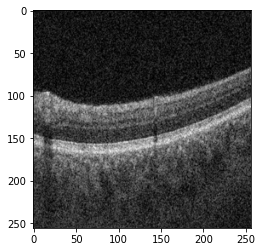

In [20]:
plt.imshow(images[0], cmap = 'gray')

In [21]:
labels = np.asarray(labels)
train_labels = np.zeros((labels.shape[0],256,256,2))

for i in range(len(labels)):
    for j in range(256):
        for k in range(256):
            if labels[i][j][k] == 0:
              train_labels[i][j][k][0] = 1
            else:
              train_labels[i][j][k][1] = 1

In [22]:
images=np.array(images)
images = images.reshape(images.shape[0],256,256,1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(images, train_labels, test_size = 0.1, random_state=42)

In [24]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [38]:
weight_decay = 0.0001
data_shape = 256*256
inputs = Input(shape=(256,256,1))
L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)

L4 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)

L7 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L8 = Activation('relu')(L8)
L9 = MaxPooling2D(pool_size=(2,2))(L8)

L10 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L9)
L11 = BatchNormalization()(L10)
L11 = Activation('relu')(L11)

L12 = UpSampling2D(size = (2,2))(L11)
L13 = Concatenate(axis = 3)([L8,L12])
L14 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L13)
L15 = BatchNormalization()(L14)
L15 = Activation('relu')(L15)

L16 = UpSampling2D(size= (2,2))(L15)
L17 = Concatenate(axis = 3)([L16,L5])
L18 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L19 = Activation('relu')(L19)

L20 = UpSampling2D(size=(2,2),name = "Layer19")(L19)
L21 = Concatenate(axis=3)([L20,L2])
L22 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L21)
L23 = BatchNormalization()(L22)
L23 = Activation('relu')(L23)

L24 = Conv2D(2,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L23)
L = Activation('softmax')(L24)

model = Model(inputs = inputs, outputs = L)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 256, 256, 64  256        ['conv2d_8[0][0]']               
 rmalization)                   )                                                           

In [26]:
smooth = 1

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)

def customized_loss(y_true,y_pred):
    return (1*K.categorical_crossentropy(y_true, y_pred))+(0.5*dice_coefficient_loss(y_true, y_pred))

In [39]:
optimiser = optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=optimiser,loss=customized_loss,metrics=['accuracy',dice_coefficient],sample_weight_mode='temporal')

In [40]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Relaynet.csv')
model_chekpoint = ModelCheckpoint("Relaynet.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [41]:
history = model.fit(X_train,y_train,batch_size=20,epochs=100,validation_data=(X_test,y_test),callbacks=[lr_reducer, csv_logger,model_chekpoint])

Epoch 1/100
13/23 [===============>..............] - ETA: 3:18 - loss: -0.1020 - accuracy: 0.8923 - dice_coefficient: 0.8664

KeyboardInterrupt: 

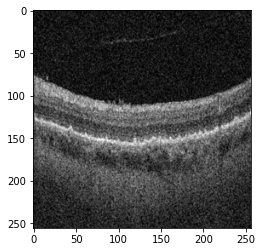

In [31]:
testing_image = X_test[25]
plt.imshow(np.squeeze(testing_image,axis = 2),cmap = "gray")

In [32]:
testing_image = testing_image.reshape((1,256,256,1))

In [30]:
model.load_weights("Relaynet.hdf5")

In [33]:
prediction = model.predict(testing_image)

1/1 [==============================] - 2s 2s/step


In [34]:
prediction = np.squeeze(prediction,axis = 0)
print(prediction.shape)

(256, 256, 2)


In [35]:
def labeled_image_to_color(image):

  output = np.zeros((256,256))
  for i in range(256):
    for j in range(256):
      output[i][j] = np.argmax(image[i][j])
  
  final_image = np.zeros((256,256, 3))
  for j in range(256):
    for k in range(256):
      if(output[j][k]==0):
        final_image[j][k] = [0,0,0]
      else:
        final_image[j][k] = [255, 255, 255]
  return final_image

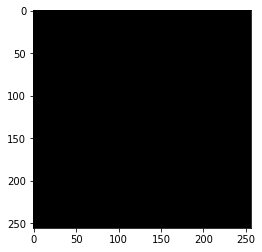

In [36]:
color = labeled_image_to_color(prediction)
plt.imshow(color, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


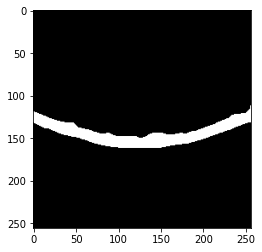

In [37]:
plt.imshow(labeled_image_to_color(y_test[25]), cmap='gray')